In [1]:
import numpy as np
import matplotlib.pyplot as plt
import analyze
from analyze import CallAggregator
from scipy import interpolate
from matplotlib.ticker import MultipleLocator, FixedLocator, NullFormatter, PercentFormatter, FuncFormatter

In [2]:
data = analyze.load_pickle(eur_only = True)

In [3]:
print(data.keys())

dict_keys(['nloci', 'ncalls', 'ngenotypes', 'ncorrect_unphased', 'ncorrect_phased', 'ncalls_not_in_ref', 'sample_acc', 'loci_acc', 'unphased_call_calibration', 'phased_call_calibration', 'unphased_genotype_calibration', 'max_chrom', 'done'])


# Analysis of unphased call calibration

Total calls: 9715796
Overall accuracy: 92.97%


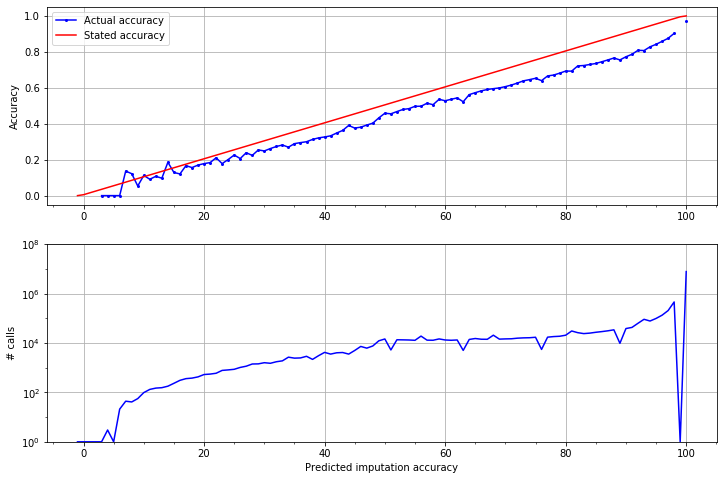

In [4]:
print("Total calls: {}".format(data['ncalls']))
#print("Overall accuracy: {:.2%}".format(data['ncorrect_unphased']/data['ncalls']))

ucc = data['unphased_call_calibration']
print("Overall accuracy: {:.2%}".format(np.sum([int(b) for b in ucc.call_successes[0:ucc.ncalls]])/ucc.ncalls))
rng = range(-1, len(ucc.call_bins)-1) #this puts true 0 calls at -1 and true 1 calls at 100
results = np.full(len(ucc.call_bins), np.nan)
call_iter = iter(ucc.call_bins.values())
success_iter = iter(ucc.success_bins.values())
idx = -1
while True:
    idx += 1
    call_num = next(call_iter, None)
    success_num = next(success_iter, None)
    if call_num is None:
        break
    if call_num == 0:
        continue
    results[idx] = success_num/call_num

figure = plt.figure(figsize=(12,8))    
#plot estimated accuracy vs true accuracy
ax1 = figure.add_subplot(2,1,1)
ax1.plot(rng, results, 'b-o', ms=2, label='Actual accuracy')
expectedResults = np.arange(0, 1, ucc.bin_size)
expectedResults += ucc.bin_size/2
expectedResults = np.concatenate(([0], expectedResults, [1]), axis=0)
ax1.plot(rng, expectedResults, 'r', label='Stated accuracy')
ax1.grid(True)
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.set_ylabel('Accuracy')
ax1.legend()
#plot estimated accuracy vs num calls with this estimate
ax2 = figure.add_subplot(2,1,2)

ys = np.array(list(ucc.call_bins.values()))
ys[ys == 0] = 1
ax2.plot(rng, ys, 'b-', ms=2)
ax2.set_yscale('log')
ax2.set_ylim((1, 1e8))
ax2.grid(True)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(FixedLocator(np.array([10**x for x in range(0, 8)])))
ax2.yaxis.set_minor_formatter(NullFormatter())
ax2.set_xlabel('Predicted imputation accuracy')
ax2.set_ylabel('# calls')
figure.show()

#TODO add error bars
#TODO do this with smoothing instead of bins

### Conclusion: Beagle overestimates its accuracy by ~5-10%

# Unphased calls by Locus 

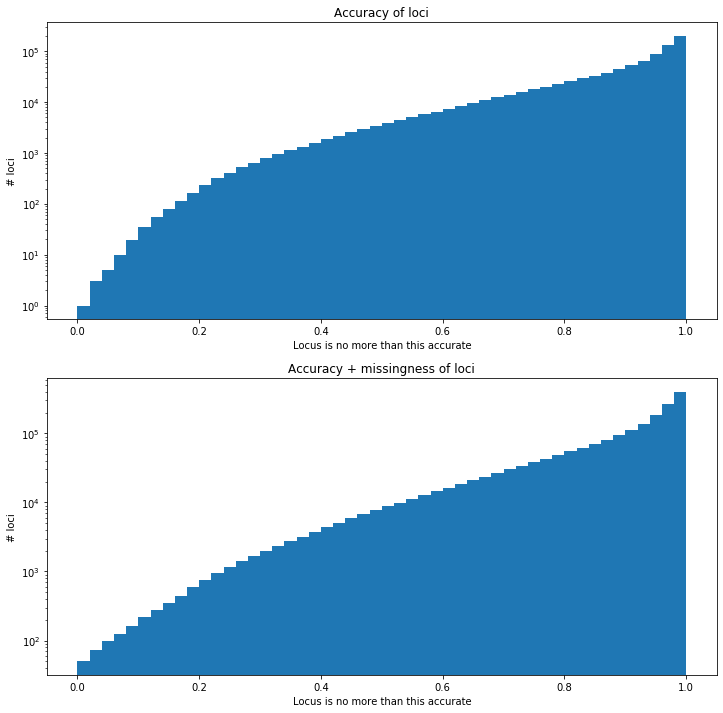

In [5]:
loc_acc = data['loci_acc']
accs = [] 
for chrom in loc_acc.keys():
    chrom = str(chrom)
    for loc in loc_acc[chrom].values():
        if loc[0] > 0:
            accs.append(loc[1]/loc[0])
figure = plt.figure(figsize=(12,12))
ax2 = figure.add_subplot(2,1,1)
ax2.hist(accs, bins=50, cumulative = True)
ax2.set_yscale('log')
ax2.set_xlabel('Locus is no more than this accurate')
ax2.set_ylabel('# loci')
ax2.set_title('Accuracy of loci')

#redo, but count missing as failures
miss_accs = [] 
for chrom in loc_acc.keys():
    chrom = str(chrom)
    for loc in loc_acc[chrom].values():
        accs.append(loc[1]/49)
ax2 = figure.add_subplot(2,1,2)
ax2.hist(accs, bins=50, cumulative = True)
ax2.set_yscale('log')
ax2.set_xlabel('Locus is no more than this accurate')
ax2.set_ylabel('# loci')
ax2.set_title('Accuracy + missingness of loci')
pass

### Could conceivably filter up to 10% of loci on accuracy issues

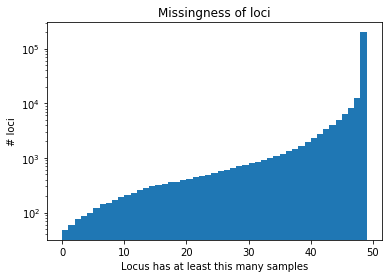

In [6]:
loc_acc = data['loci_acc']
missingness = [] 
for chrom in loc_acc.keys():
    chrom = str(chrom)
    for loc in loc_acc[chrom].values():
        missingness.append(loc[0])
figure = plt.figure()
ax2 = figure.add_subplot(1,1,1)
ax2.hist(missingness, bins=49, cumulative = True)
ax2.set_yscale('log')
ax2.set_xlabel('Locus has at least this many samples')
ax2.set_ylabel('# loci')

ax2.set_title('Missingness of loci')
pass

### Might have to filter roughly ~1% of loci on missingness issues

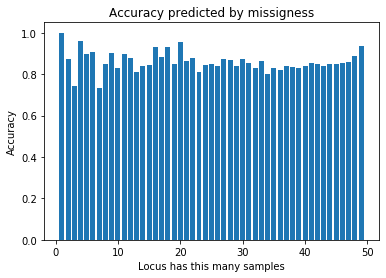

In [7]:
loc_acc = data['loci_acc']
accuracy_by_samplesize = {}
for i in range(1, 50):
    accuracy_by_samplesize[i] = []
for chrom in loc_acc.keys():
    chrom = str(chrom)
    for loc in loc_acc[chrom].values():
        if loc[0] == 0:
            continue
        accuracy_by_samplesize[loc[0]].append(loc[1]/loc[0])
summary = []
for i in range(1, 50):
    summary.append(np.mean(accuracy_by_samplesize[i]))
figure = plt.figure()
ax2 = figure.add_subplot(1,1,1)
ax2.bar(range(1,50), summary)
ax2.set_xlabel('Locus has this many samples')
ax2.set_ylabel('Accuracy')

ax2.set_title('Accuracy predicted by missigness')
#Note that this isn't totally correct
#because missingness is related to accuracy:
#so the accuracy at a certain level of missingness should be
#viewed in light of the accuracy of nearby levels of missingness as well
pass

### Not enough to see here: not enough missingness (thankfully) that's it is a driving cause of inaccuracies

# Unphased call by Sample

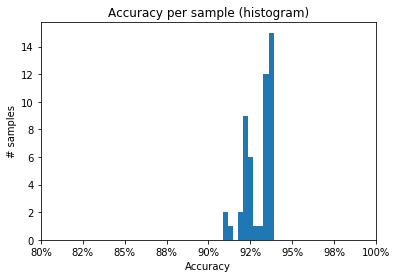

In [8]:
sample_acc = data['sample_acc']
accs = [] 
for sample in sample_acc:
        accs.append(sample_acc[sample][1]/sample_acc[sample][0])
figure = plt.figure()
accs.sort()

'''
ax1 = figure.add_subplot(2,1,1)
ax1.bar(range(len(accs)), accs)
ax1.set_ylim(0,1)
'''

def formatter(num, pos):
    return "{:.0%}".format(num)

ax2 = figure.add_subplot(1,1,1)
ax2.hist(accs)
ax2.set_xlim(.8, 1)
ax2.xaxis.set_major_formatter(FuncFormatter(formatter))
ax2.set_title('Accuracy per sample (histogram)')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('# samples')
pass

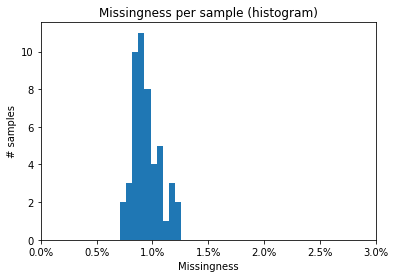

In [9]:
#sample missingness rates
figure = plt.figure()
ax2 = figure.add_subplot(1,1,1)

missingness = []
sample_acc = data['sample_acc']
total_loci = np.sum([x for x in data['nloci'].values()])
for sample in sample_acc:
    missingness.append((total_loci - sample_acc[sample][0])/total_loci)
ax2.hist(missingness)
ax2.set_xlim(0, .03)
def formatter(num, pos):
    return "{:.1%}".format(num)
ax2.xaxis.set_major_formatter(FuncFormatter(formatter))
ax2.set_title('Missingness per sample (histogram)')
ax2.set_xlabel('Missingness')
ax2.set_ylabel('# samples')
pass

### Conclusion: samples all have roughly the same accuracy and missingness

# Unphased genotypes

In [10]:
print(data['ngenotypes'], data['unphased_genotype_calibration'].ncalls)

{'1': 860310.0, '2': 925099.0, '3': 780372.0, '4': 756355.0, '5': 737793.0, '6': 743444.0, '7': 617917.0, '8': 585728.0, '9': 460141.0, '10': 492589.0, '11': 551055.0, '12': 590163.0, '13': 408380.0, '14': 373315.0, '15': 295739.0, '16': 315901.0, '17': 328083.0, '18': 336343.0, '19': 228848.0, '20': 239846.0, '21': 173577.0, '22': 128245.0} 535029798


Total genotypes: 10929243.0


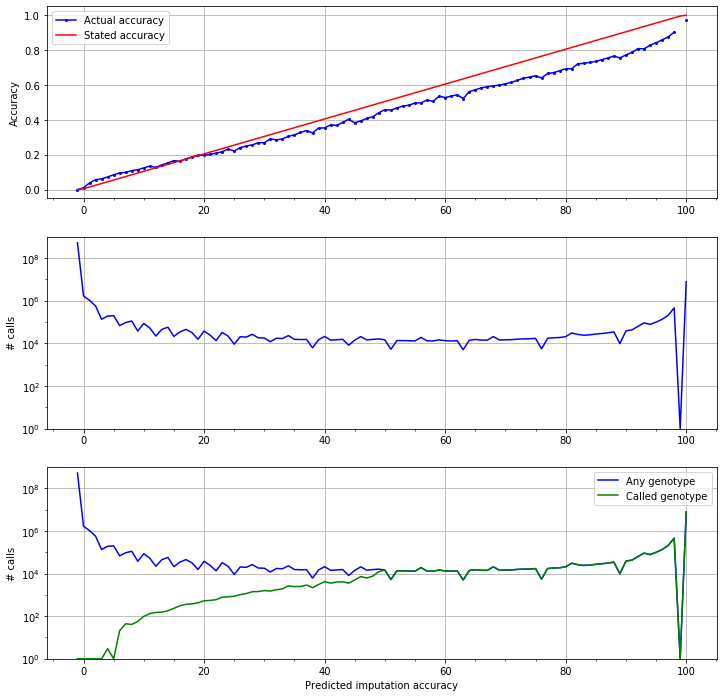

In [11]:
print("Total genotypes: {}".format(np.sum([x for x in data['ngenotypes'].values()])))

ugc = data['unphased_genotype_calibration']
rng = range(-1, len(ugc.call_bins)-1) #this puts true 0 calls at -1 and true 1 calls at 100
results = np.full(len(ugc.call_bins), np.nan)
call_iter = iter(ugc.call_bins.values())
success_iter = iter(ugc.success_bins.values())
idx = -1
while True:
    idx += 1
    call_num = next(call_iter, None)
    success_num = next(success_iter, None)
    if call_num is None:
        break
    if call_num == 0:
        continue
    results[idx] = success_num/call_num

figure = plt.figure(figsize=(12,12))    
#plot estimated accuracy vs true accuracy
ax1 = figure.add_subplot(3,1,1)
ax1.plot(rng, results, 'b-o', ms=2, label='Actual accuracy')
expectedResults = np.arange(0, 1, ugc.bin_size)
expectedResults += ugc.bin_size/2
expectedResults = np.concatenate(([0], expectedResults, [1]), axis=0)
ax1.plot(rng, expectedResults, 'r', label='Stated accuracy')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.legend()

#plot estimated accuracy vs num genotypes with this estimate
ax2 = figure.add_subplot(3,1,2)

ys = np.array(list(ugc.call_bins.values()))
ys[ys == 0] = 1
ax2.plot(rng, ys, 'b-', ms=2)
ax2.set_yscale('log')
ax2.set_ylim((1, 1e9))
ax2.grid(True)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(FixedLocator(np.array([10**x for x in range(0, 8)])))
ax2.yaxis.set_minor_formatter(NullFormatter())
ax2.set_ylabel('# calls')
figure.show()

#plot num calls with this estimate and num genotypes with this estimate
ax3 = figure.add_subplot(3,1,3)

ys1 = np.array(list(ugc.call_bins.values()))
ys1[ys1 == 0] = 1
ys2 = np.array(list(data['unphased_call_calibration'].call_bins.values()))
ys2[ys2 == 0] = 1
ax3.plot(rng, ys1, 'b-', ms=2, label="Any genotype")
ax3.plot(rng, ys2, 'g-', ms=2, label="Called genotype")
ax3.set_yscale('log')
ax3.set_ylim((1, 1e9))
ax3.grid(True)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(FixedLocator(np.array([10**x for x in range(0, 8)])))
ax3.yaxis.set_minor_formatter(NullFormatter())
ax3.set_xlabel('Predicted imputation accuracy')
ax3.legend()
ax3.set_ylabel('# calls')
figure.show()


#TODO add error bars
#TODO do this with smoothing instead of bins

# Phased Calls

Total calls: 9715796
Overall accuracy: 92.97%


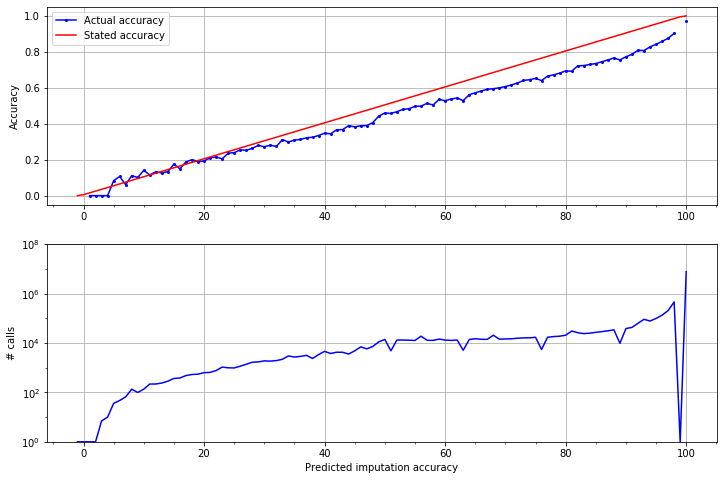

In [12]:
print("Total calls: {}".format(data['ncalls']))
#print("Overall accuracy: {:.2%}".format(
#    data['ncorrect_phased']/data['ncalls']))

pcc = data['phased_call_calibration']
print("Overall accuracy: {:.2%}".format(np.sum([int(b) for b in pcc.call_successes[:pcc.ncalls]])/pcc.ncalls))
rng = range(-1, len(pcc.call_bins)-1) #this puts true 0 calls at -1 and true 1 calls at 100
results = np.full(len(pcc.call_bins), np.nan)
call_iter = iter(pcc.call_bins.values())
success_iter = iter(pcc.success_bins.values())
idx = -1
while True:
    idx += 1
    call_num = next(call_iter, None)
    success_num = next(success_iter, None)
    if call_num is None:
        break
    if call_num == 0:
        continue
    results[idx] = success_num/call_num

figure = plt.figure(figsize=(12,8))    
#plot estimated accuracy vs true accuracy
ax1 = figure.add_subplot(2,1,1)
ax1.plot(rng, results, 'b-o', ms=2, label='Actual accuracy')
expectedResults = np.arange(0, 1, pcc.bin_size)
expectedResults += pcc.bin_size/2
expectedResults = np.concatenate(([0], expectedResults, [1]), axis=0)
ax1.plot(rng, expectedResults, 'r', label='Stated accuracy')
ax1.grid(True)
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.set_ylabel('Accuracy')
ax1.legend()
#plot estimated accuracy vs num calls with this estimate
ax2 = figure.add_subplot(2,1,2)

ys = np.array(list(pcc.call_bins.values()))
ys[ys == 0] = 1
ax2.plot(rng, ys, 'b-', ms=2)
ax2.set_yscale('log')
ax2.set_ylim((1, 1e8))
ax2.grid(True)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(FixedLocator(np.array([10**x for x in range(0, 8)])))
ax2.yaxis.set_minor_formatter(NullFormatter())
ax2.set_xlabel('Predicted imputation accuracy')
ax2.set_ylabel('# calls')
figure.show()

#TODO add error bars
#TODO do this with smoothing instead of bins

In [13]:
# Phased vs unphased confusion matrix
ucc = data['unphased_call_calibration']
pcc = data['phased_call_calibration']
confusion = np.array([[0,0],[0,0]])
if ucc.ncalls != pcc.ncalls:
        print("different ncalls!")
for idx in range(ucc.ncalls):
    ucc_success = int(ucc.call_successes[idx])
    pcc_success = int(pcc.call_successes[idx])
    confusion[1 - ucc_success][1 - pcc_success] += 1

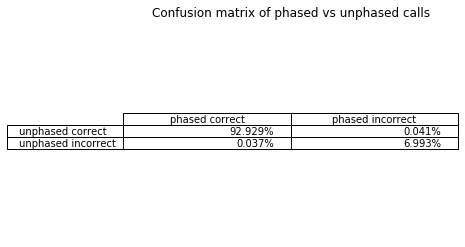

In [14]:
confusionPercs = [[0,0],[0,0]]
for idx1 in range(2):
    for idx2 in range(2):
        confusionPercs[idx1][idx2] = "{:.3%}".format(confusion[idx1, idx2]/ucc.ncalls)
figure = plt.figure()
ax = figure.add_subplot(1,1,1)
ax.set_title("Confusion matrix of phased vs unphased calls")
ax.table(cellText=confusionPercs, loc='center',
        rowLabels = ['unphased correct', 'unphased incorrect'],
        colLabels = ['phased correct', 'phased incorrect'])
ax.axis('off')
ax.axis('tight')

pass

### Conclusion: no difference in looking at phased vs unphased calls

In [15]:
#reference
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep
#can't get this to work ...
#maybe because there are duplicate x values?
#maybe because the x-values aren't sorted?
ucc = data['unphased_call_calibration']
spline = interpolate.splrep(ucc.calls[:ucc.ncalls], np.array(ucc.call_successes[:ucc.ncalls], dtype=float), s = 100000, xb=0, xe=1)
xs = np.linspace(0, 1, 1000)
ys = interpolate.splev(xs, spline)
plt.plot(xs, ys)

ValueError: Error on input data